<br>
<h1 style = "font-size:30px; font-weight : bold; color : blue; text-align: center; border-radius: 10px 15px;">Chest X-Ray (Pneumonia): Image Classification w/Convolutional Neural Networks and Transfer Learning</h1>
<br>

---

# Overview

The goal of this notebook is to use Convolutional Neural Networks on Chest X-Ray images to determine which samples are from patients with Pneumonia. In this dataset (version 3), there is one folder representing the train set and another one for the test set. The train folder is later split in the notebook into train/validation sets.

I use three different approaches for image classification: 1) A simple CNN, 2) Transfer Learning, using a pretrained model with frozen layers as the base for feature extraction and 3) Fine Tuning, unfreezing the last layers of the pretrained model.

Note: I’m using the third version of the Chest X-Ray dataset [(link)](https://data.mendeley.com/datasets/rscbjbr9sj/3)

# <a id='0'>Content</a>
​
- <a href='#1'>Dataset Information</a>  
- <a href='#2'>Importing Packages</a>  
- <a href='#10'>Data Processing</a>
- <a href='#3'>Exploring the Data</a>  
- <a href='#4'>Preparing the Data</a>
- <a href='#5'>Custom Model</a>
- <a href='#6'>Transfer Learning</a>
- <a href='#7'>Fine Tuning</a>
- <a href='#8'>Performance Metrics</a>
- <a href='#9'>References</a>

# <a id="1">Dataset Information</a>

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

# <a id="2">Importing Packages</a>

In [ ]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

# <a id="10">Data Processing</a>

In [ ]:
import os
os.environ["KAGGLE_USERNAME"]="saisrushikgovindgari"
os.environ["KAGGLE_KEY"]="d3376b328296c593a7b210aafc6fd39e"

In [ ]:
!kaggle datasets download saisrushikgovindgari/chest-xray-radiography-dataset

100% 1.17G/1.17G [00:49<00:00, 30.8MB/s]
100% 1.17G/1.17G [00:49<00:00, 25.4MB/s]


In [ ]:
!unzip chest-xray-radiography-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [ ]:

main_path = "/content/chest_xray/"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [ ]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [ ]:
df_train

class  \
0        Normal   
1        Normal   
2        Normal   
3        Normal   
4        Normal   
...         ...   
5227  Pneumonia   
5228  Pneumonia   
5229  Pneumonia   
5230  Pneumonia   
5231  Pneumonia   

                                                               image  
0          /content/chest_xray/train/NORMAL/NORMAL-1507671-0001.jpeg  
1          /content/chest_xray/train/NORMAL/NORMAL-2992797-0002.jpeg  
2          /content/chest_xray/train/NORMAL/NORMAL-6710847-0002.jpeg  
3          /content/chest_xray/train/NORMAL/NORMAL-9015104-0001.jpeg  
4          /content/chest_xray/train/NORMAL/NORMAL-4047118-0001.jpeg  
...                                                              ...  
5227  /content/chest_xray/train/PNEUMONIA/BACTERIA-5150733-0002.jpeg  
5228  /content/chest_xray/train/PNEUMONIA/BACTERIA-6076468-0002.jpeg  
5229  /content/chest_xray/train/PNEUMONIA/BACTERIA-4816687-0002.jpeg  
5230     /content/chest_xray/train/PNEUMONIA/VIRUS-1076722-0003.jpeg  
5231  /content/chest_xray/train/PNEUMONIA/BACTERIA-8738712-0001.jpeg  

[5232 rows x 2 columns]

In [ ]:
df_test

class                                                          image
0       Normal       /content/chest_xray/test/NORMAL/NORMAL-2107985-0001.jpeg
1       Normal       /content/chest_xray/test/NORMAL/NORMAL-6085151-0001.jpeg
2       Normal       /content/chest_xray/test/NORMAL/NORMAL-1160949-0001.jpeg
3       Normal       /content/chest_xray/test/NORMAL/NORMAL-2578531-0001.jpeg
4       Normal       /content/chest_xray/test/NORMAL/NORMAL-3322209-0001.jpeg
..         ...                                                            ...
619  Pneumonia  /content/chest_xray/test/PNEUMONIA/BACTERIA-5155977-0004.jpeg
620  Pneumonia  /content/chest_xray/test/PNEUMONIA/BACTERIA-4167818-0003.jpeg
621  Pneumonia      /content/chest_xray/test/PNEUMONIA/VIRUS-820420-0001.jpeg
622  Pneumonia  /content/chest_xray/test/PNEUMONIA/BACTERIA-3060399-0004.jpeg
623  Pneumonia     /content/chest_xray/test/PNEUMONIA/VIRUS-8106836-0001.jpeg

[624 rows x 2 columns]

# <a id="3">Exploring the Data</a>

Let's check the target distribution on each set

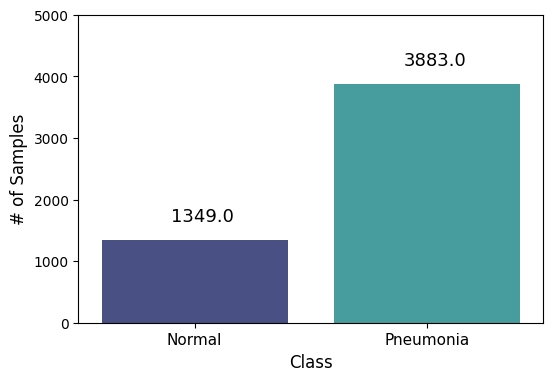

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)

plt.show()

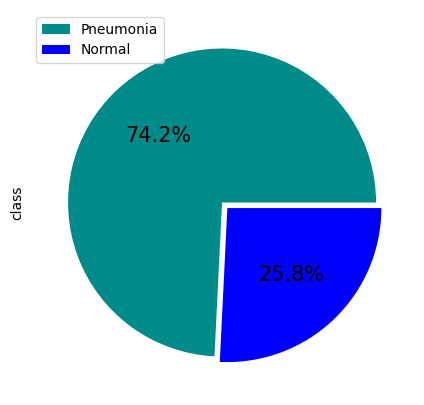

In [ ]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

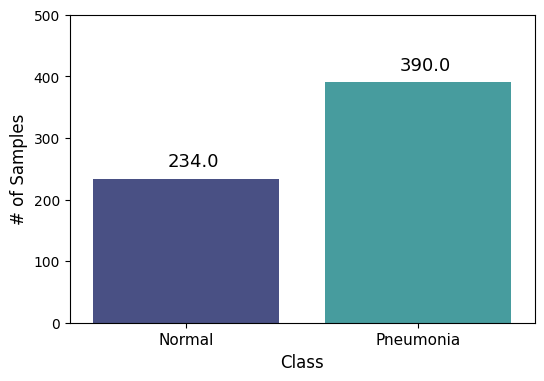

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)

plt.show()

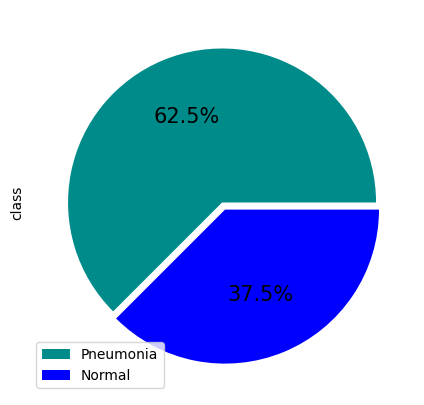

In [ ]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

The distributions from these datasets are a little different from each other. Both are slightly imbalanced, having more samples from the positive class (Pneumonia), with the training set being a little more imbalanced.

Before we move on to the next section, we will take a look at a few examples from each dataset.

Train Set - Normal


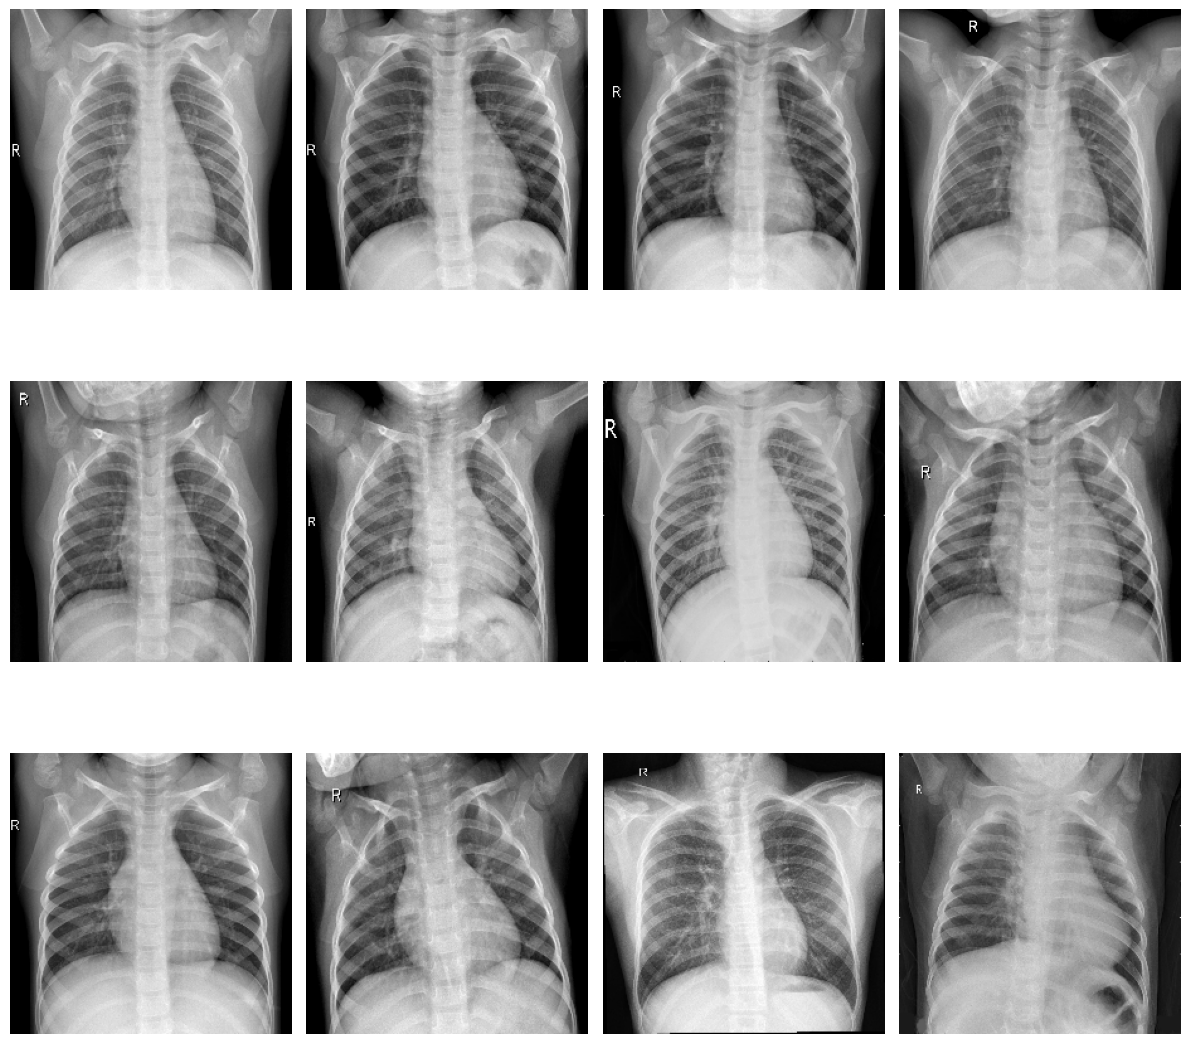

In [ ]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


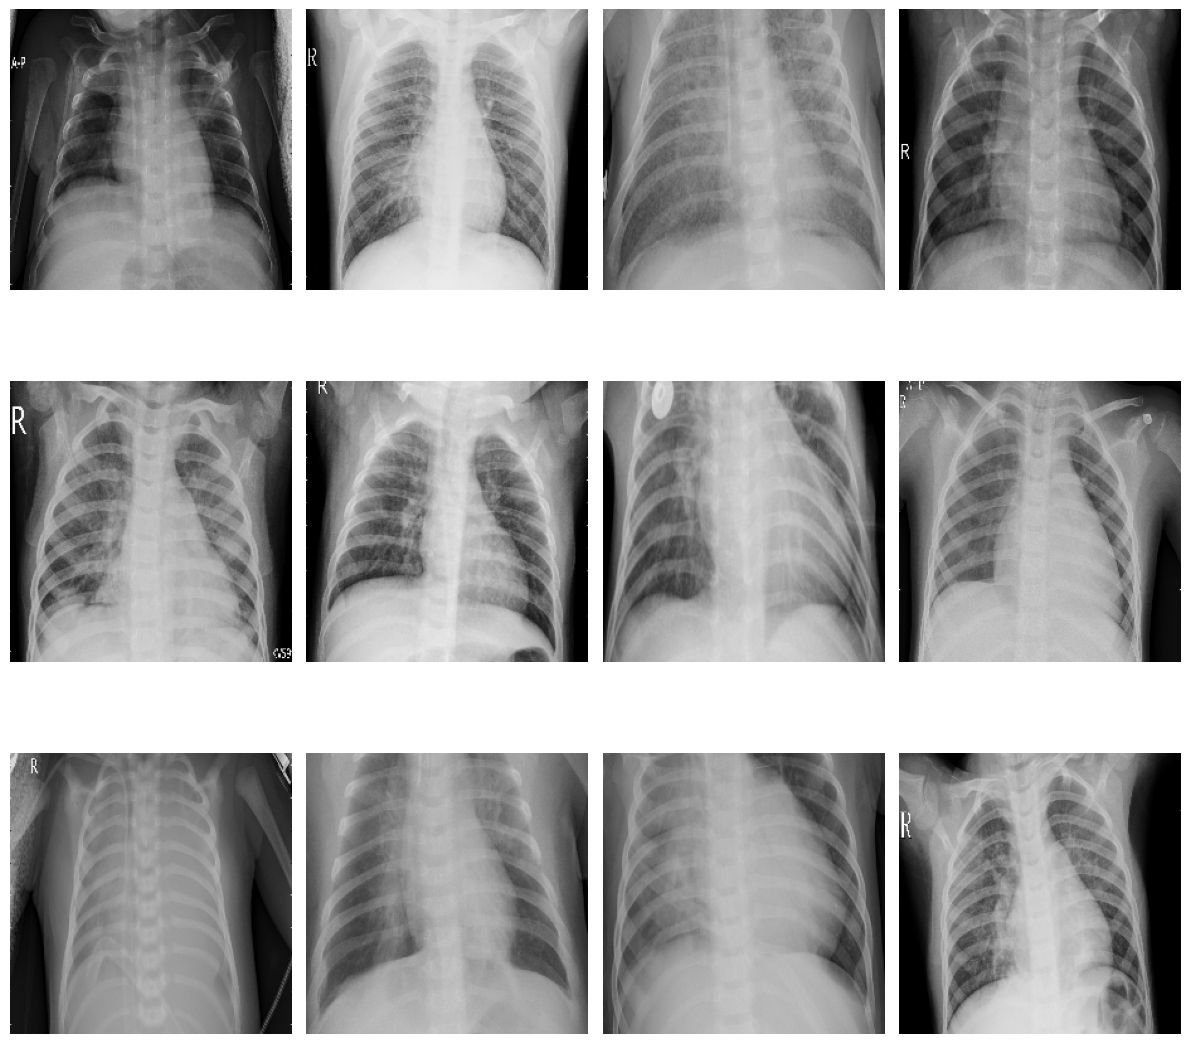

In [ ]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Normal


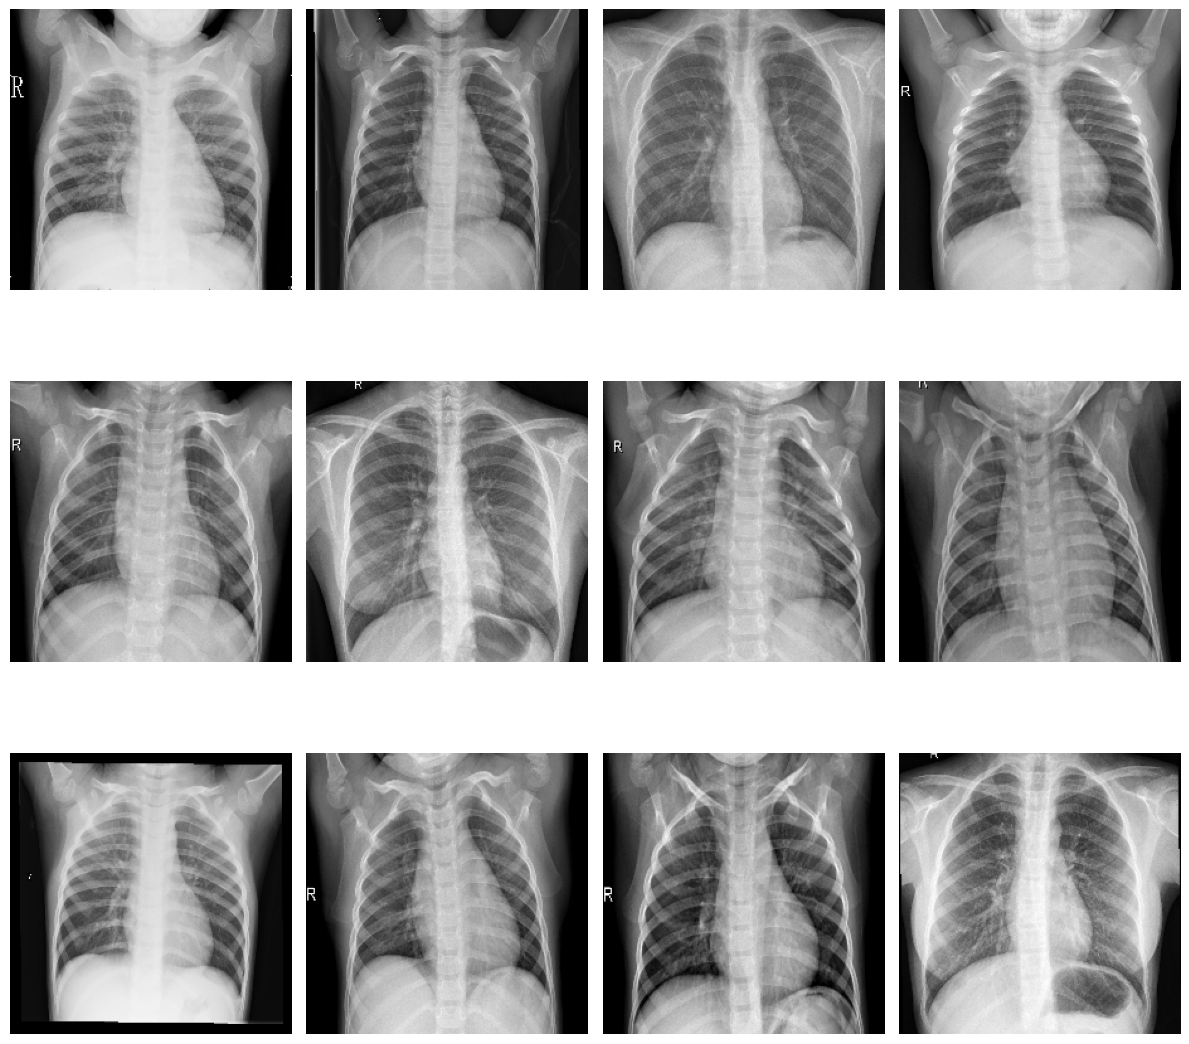

In [ ]:
print('Test Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Pneumonia


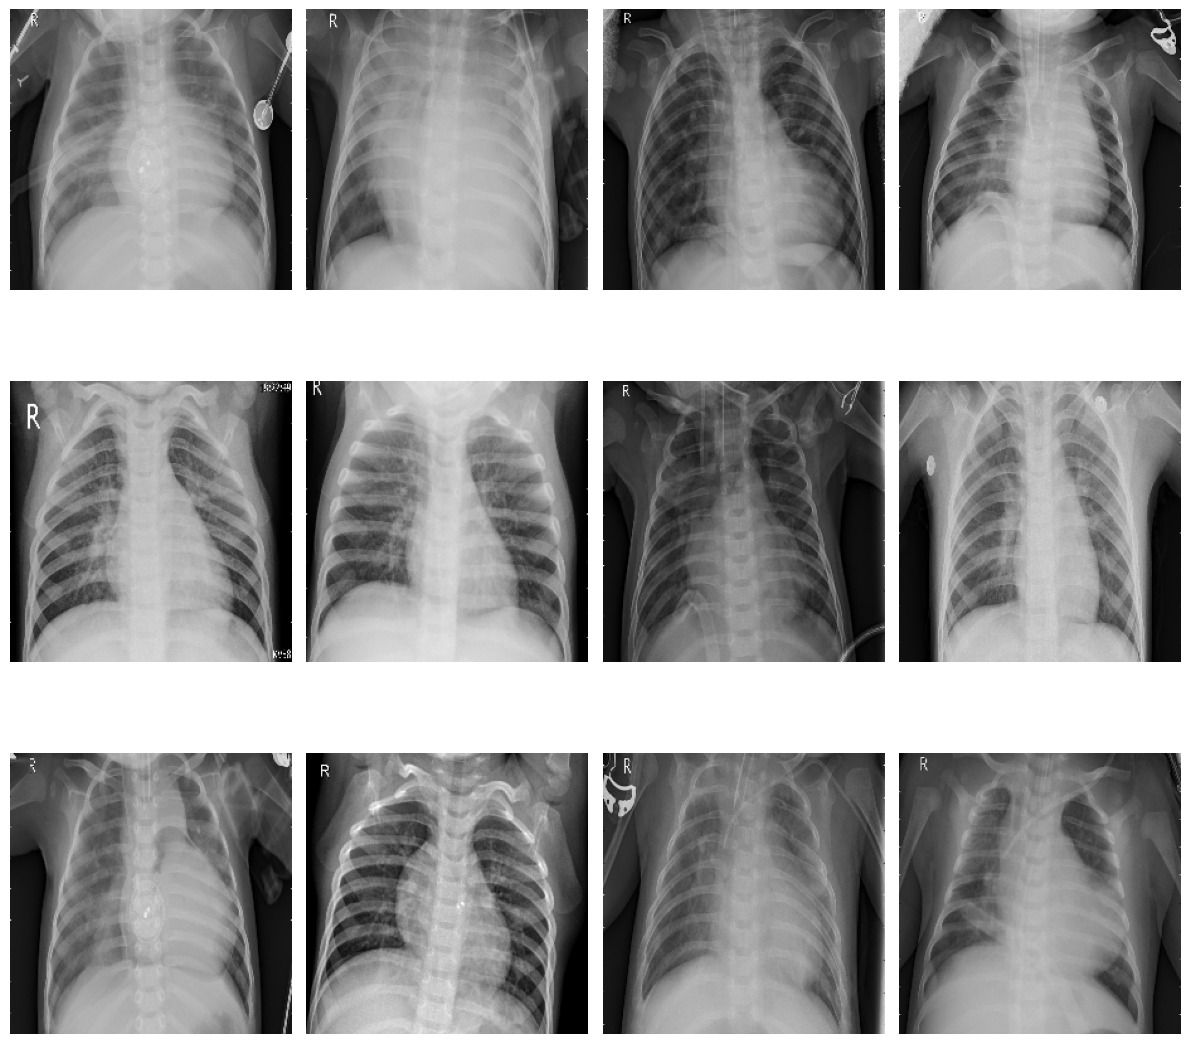

In [ ]:
print('Test Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

# <a id="4">Preparing the Data</a>

First, we need to create a validation set. To do that, we apply a simple stratified split on the original train dataset, using 80% for actual training and 20% for validation purposes.

In [ ]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [ ]:
train_df

class  \
3566  Pneumonia   
2866  Pneumonia   
2681  Pneumonia   
1199     Normal   
4619  Pneumonia   
...         ...   
3476  Pneumonia   
678      Normal   
1560  Pneumonia   
2769  Pneumonia   
4881  Pneumonia   

                                                               image  
3566     /content/chest_xray/train/PNEUMONIA/VIRUS-9727803-0002.jpeg  
2866  /content/chest_xray/train/PNEUMONIA/BACTERIA-1332623-0001.jpeg  
2681     /content/chest_xray/train/PNEUMONIA/VIRUS-9844887-0001.jpeg  
1199       /content/chest_xray/train/NORMAL/NORMAL-9061361-0001.jpeg  
4619  /content/chest_xray/train/PNEUMONIA/BACTERIA-8321175-0002.jpeg  
...                                                              ...  
3476      /content/chest_xray/train/PNEUMONIA/VIRUS-289775-0001.jpeg  
678        /content/chest_xray/train/NORMAL/NORMAL-4056615-0002.jpeg  
1560  /content/chest_xray/train/PNEUMONIA/BACTERIA-5626093-0005.jpeg  
2769     /content/chest_xray/train/PNEUMONIA/VIRUS-7933423-0002.jpeg  
4881  /content/chest_xray/train/PNEUMONIA/BACTERIA-7432256-0004.jpeg  

[4185 rows x 2 columns]

In [ ]:
val_df

class  \
2945  Pneumonia   
4878  Pneumonia   
3177  Pneumonia   
972      Normal   
3059  Pneumonia   
...         ...   
253      Normal   
4315  Pneumonia   
687      Normal   
3417  Pneumonia   
3745  Pneumonia   

                                                               image  
2945  /content/chest_xray/train/PNEUMONIA/BACTERIA-2739133-0001.jpeg  
4878  /content/chest_xray/train/PNEUMONIA/BACTERIA-5150733-0014.jpeg  
3177     /content/chest_xray/train/PNEUMONIA/VIRUS-8133734-0002.jpeg  
972        /content/chest_xray/train/NORMAL/NORMAL-5606086-0001.jpeg  
3059   /content/chest_xray/train/PNEUMONIA/BACTERIA-452131-0001.jpeg  
...                                                              ...  
253        /content/chest_xray/train/NORMAL/NORMAL-6688691-0001.jpeg  
4315  /content/chest_xray/train/PNEUMONIA/BACTERIA-3722564-0002.jpeg  
687        /content/chest_xray/train/NORMAL/NORMAL-7659145-0001.jpeg  
3417  /content/chest_xray/train/PNEUMONIA/BACTERIA-7630183-0002.jpeg  
3745  /content/chest_xray/train/PNEUMONIA/BACTERIA-7979755-0001.jpeg  

[1047 rows x 2 columns]

Now, we’re going to load the images from the folders and prepare them to feed our models.

We begin by defining the data generators. With Keras Image Data Generator, we can rescale the pixel values and apply random transformation techniques for data augmentation on the fly. We define two different generators. The val_datagen is used to simply rescale the validation and test sets. The train_datagen includes some transformations to augment the train set.

We apply those generators on each dataset using the flow_from_dataframe method. Apart from the transformations defined in each generator, the images are also resized based on the target_size set.

In [ ]:


train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Now, we are ready for the next stage: creating and training the image classification models.

# <a id="5">Custom CNN</a>

In [ ]:
#Setting callbakcs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

Let’s define our first model ‘from scratch’ and see how it performs.

In [ ]:
def get_model():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

In [ ]:
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=3e-5), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0     

In [ ]:
history = model.fit(ds_train,
          batch_size = BATCH, epochs = 70,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/70
130/130 [==============================] - 117s 780ms/step - loss: 0.4687 - binary_accuracy: 0.8024 - val_loss: 1.1612 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 2/70
130/130 [==============================] - 100s 762ms/step - loss: 0.3116 - binary_accuracy: 0.8643 - val_loss: 1.9876 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 3/70
131/130 [==============================] - ETA: 0s - loss: 0.2626 - binary_accuracy: 0.8889
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.9999998484272515e-06.
130/130 [==============================] - 99s 760ms/step - loss: 0.2626 - binary_accuracy: 0.8889 - val_loss: 1.8550 - val_binary_accuracy: 0.7421 - lr: 3.0000e-05
Epoch 4/70
130/130 [==============================] - 100s 763ms/step - loss: 0.2271 - binary_accuracy: 0.9109 - val_loss: 1.2251 - val_binary_accuracy: 0.7431 - lr: 6.0000e-06
Epoch 5/70
130/130 [==============================] - 99s 761ms/step - loss: 0.2222 - binary_accuracy: 0.9102 - val_loss: 0.

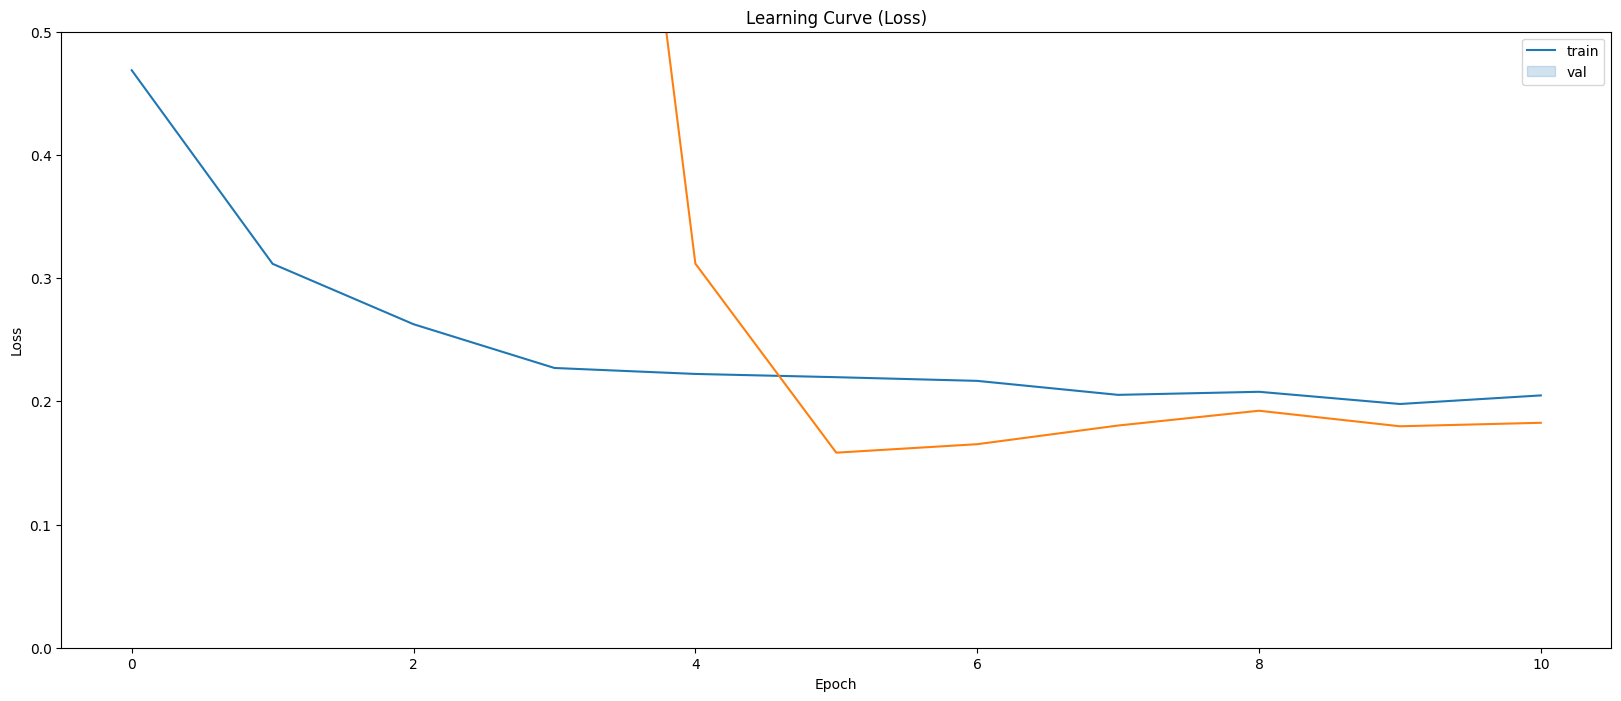

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

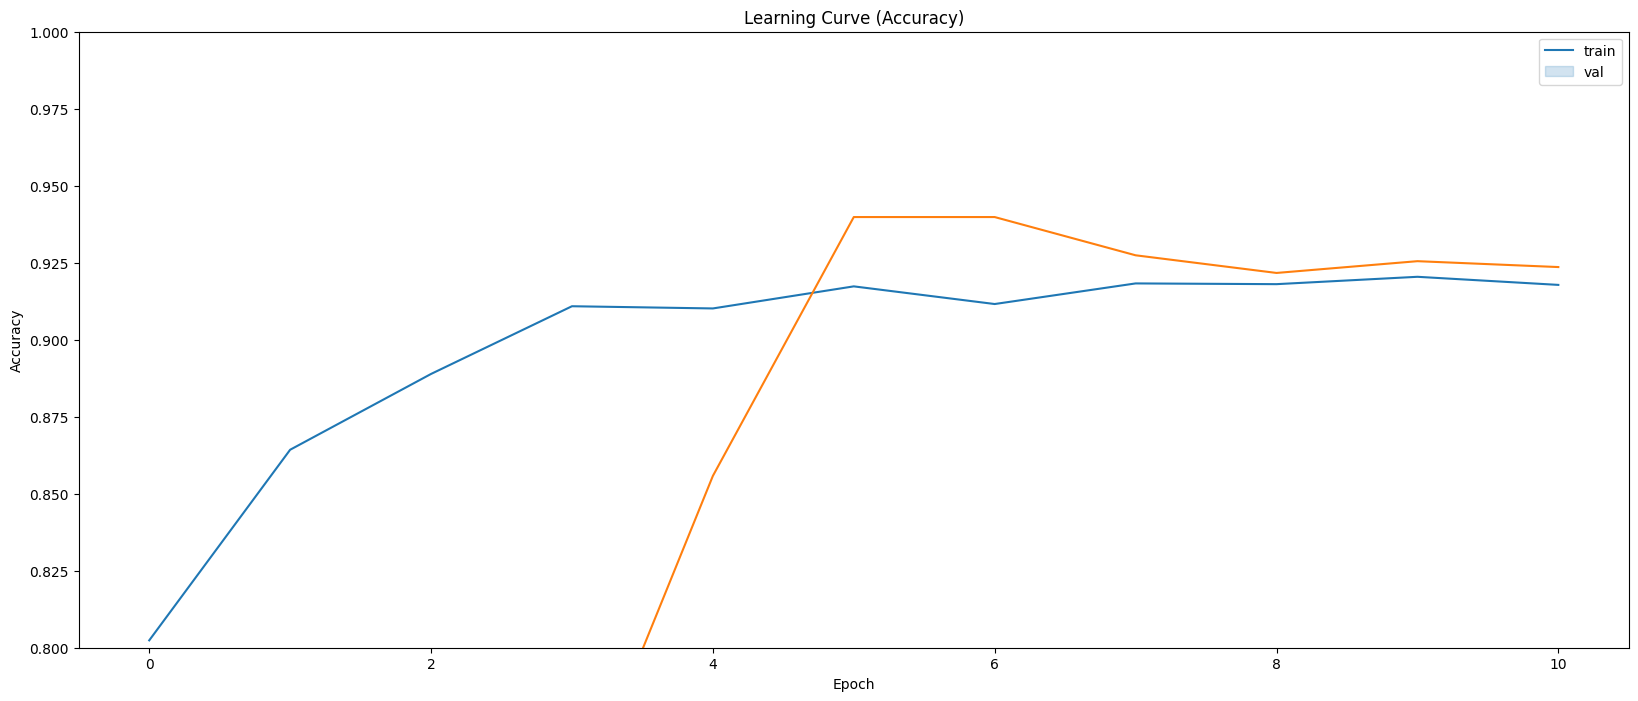

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1583232432603836
Val accuracy: 0.939828097820282


In [ ]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3614896535873413
Test accuracy: 0.8653846383094788


# <a id="6">Transfer Learning</a>

The second approach, called transfer learning, consists of using a pretrained model as a feature extractor. In this notebook, the selected model was the VGG19 available on the Keras Package [(link)](https://keras.io/api/applications/vgg/).

This model was already trained in another dataset (ImageNet). What we do here is to set include_top to false, removing the ‘head’, responsible for assigning the classes in this other dataset, and keep all the previous layers. Then, we include our last few layers, including the one responsible for generating the output.



In [ ]:
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

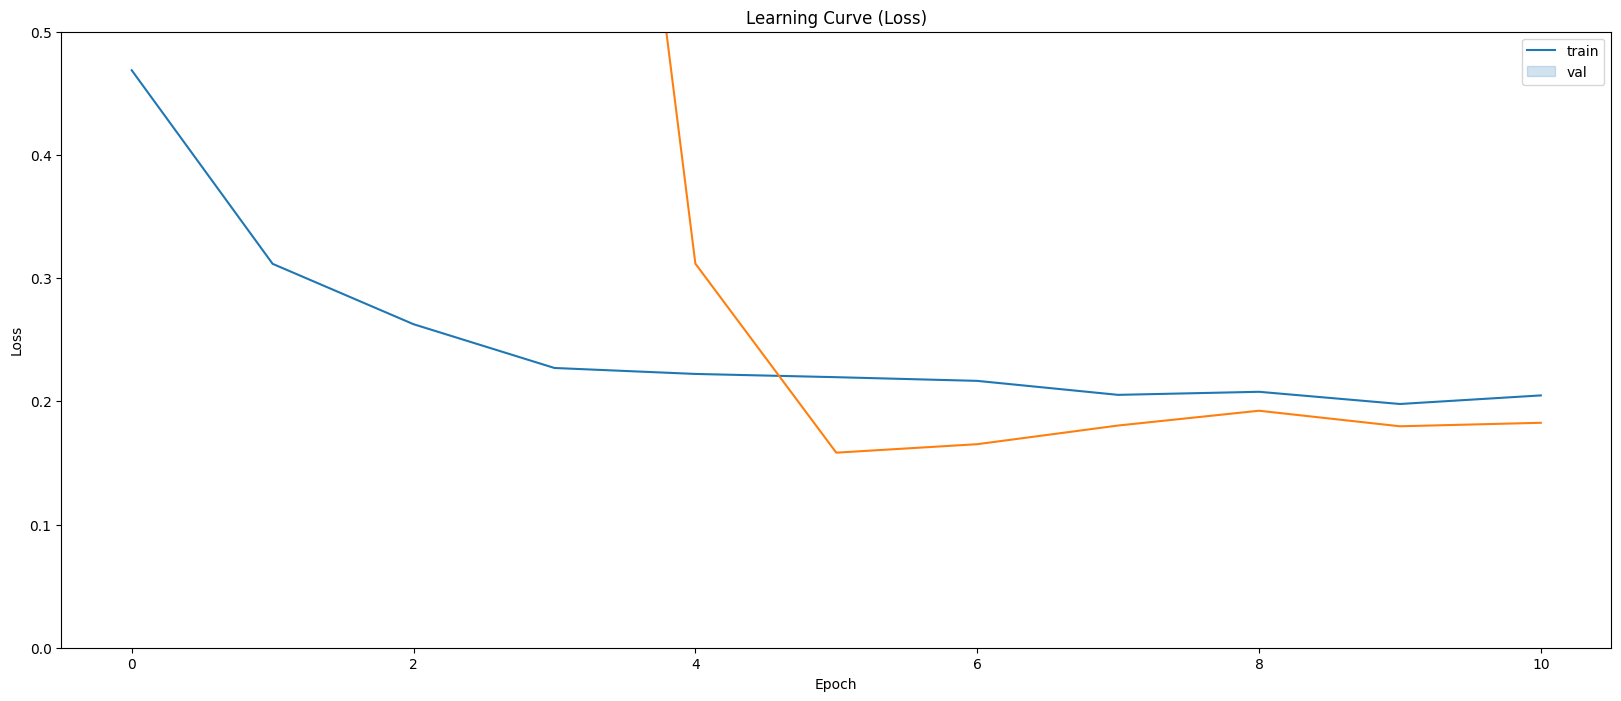

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

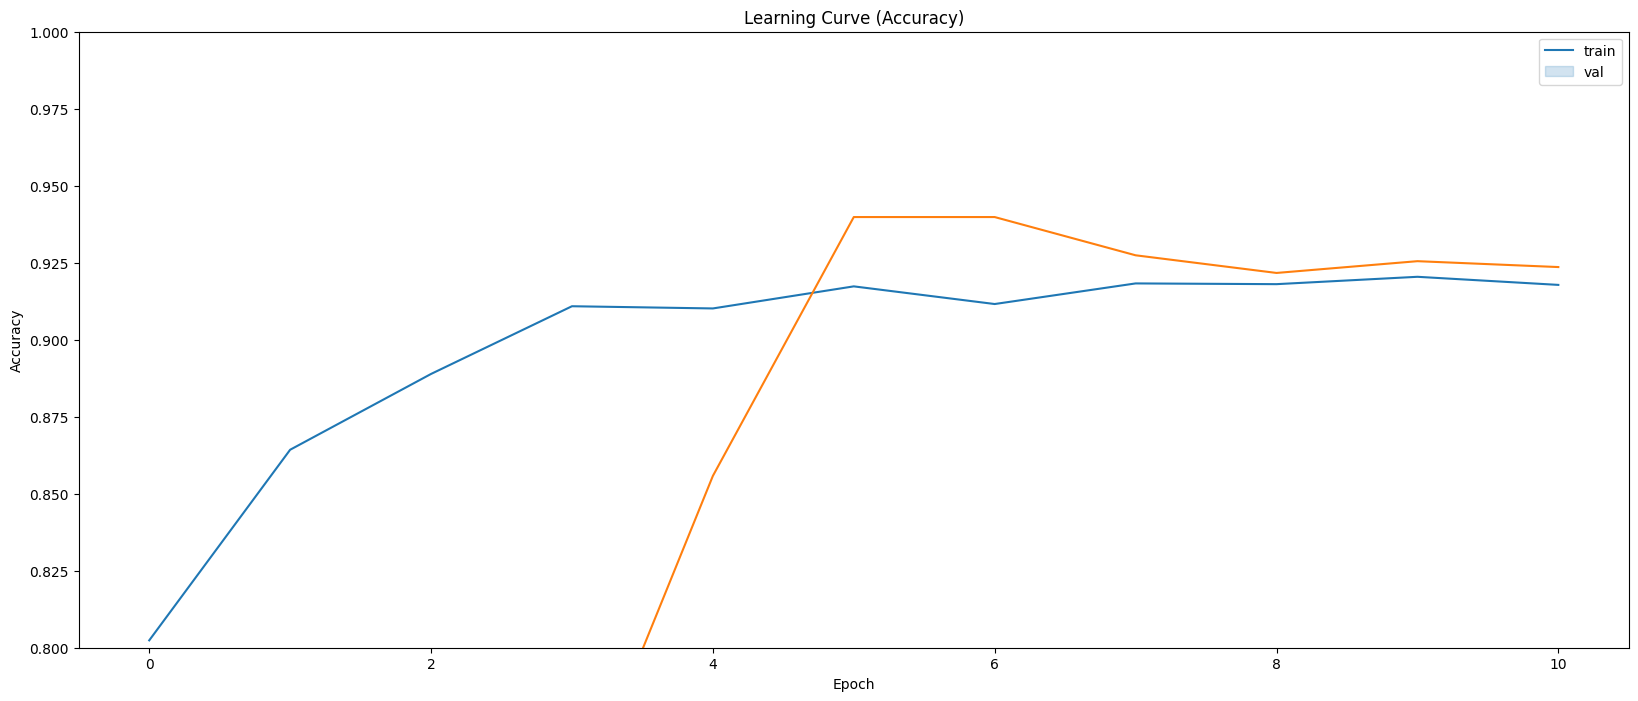

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.8908789157867432
Val accuracy: 0.2578796446323395


In [ ]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.822494626045227
Test accuracy: 0.375


# <a id="7">Fine Tuning</a>

Our last approach is called Fine Tuning. In the last section, all the layers from the pretrained model were ‘frozen’, preserving the weights calculated during its training on the ImageNet dataset. Now, we are going to unfreeze a few of its last layers and continue the training, tuning the weights from these layers according to our dataset.

In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-13]:
    layer.trainable = False

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [ ]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=2e-6), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 70,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/70
130/130 [==============================] - 142s 1s/step - loss: 0.4521 - binary_accuracy: 0.7458 - val_loss: 0.2150 - val_binary_accuracy: 0.9169 - lr: 2.0000e-06
Epoch 2/70
130/130 [==============================] - 129s 988ms/step - loss: 0.1887 - binary_accuracy: 0.9317 - val_loss: 0.1614 - val_binary_accuracy: 0.9341 - lr: 2.0000e-06
Epoch 3/70
130/130 [==============================] - 128s 983ms/step - loss: 0.1267 - binary_accuracy: 0.9539 - val_loss: 0.2060 - val_binary_accuracy: 0.9179 - lr: 2.0000e-06
Epoch 4/70
131/130 [==============================] - ETA: 0s - loss: 0.1052 - binary_accuracy: 0.9613
Epoch 4: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
130/130 [==============================] - 128s 979ms/step - loss: 0.1052 - binary_accuracy: 0.9613 - val_loss: 0.1637 - val_binary_accuracy: 0.9341 - lr: 2.0000e-06
Epoch 5/70
130/130 [==============================] - 135s 1s/step - loss: 0.0939 - binary_accuracy: 0.9682 - val_loss: 0.1394 

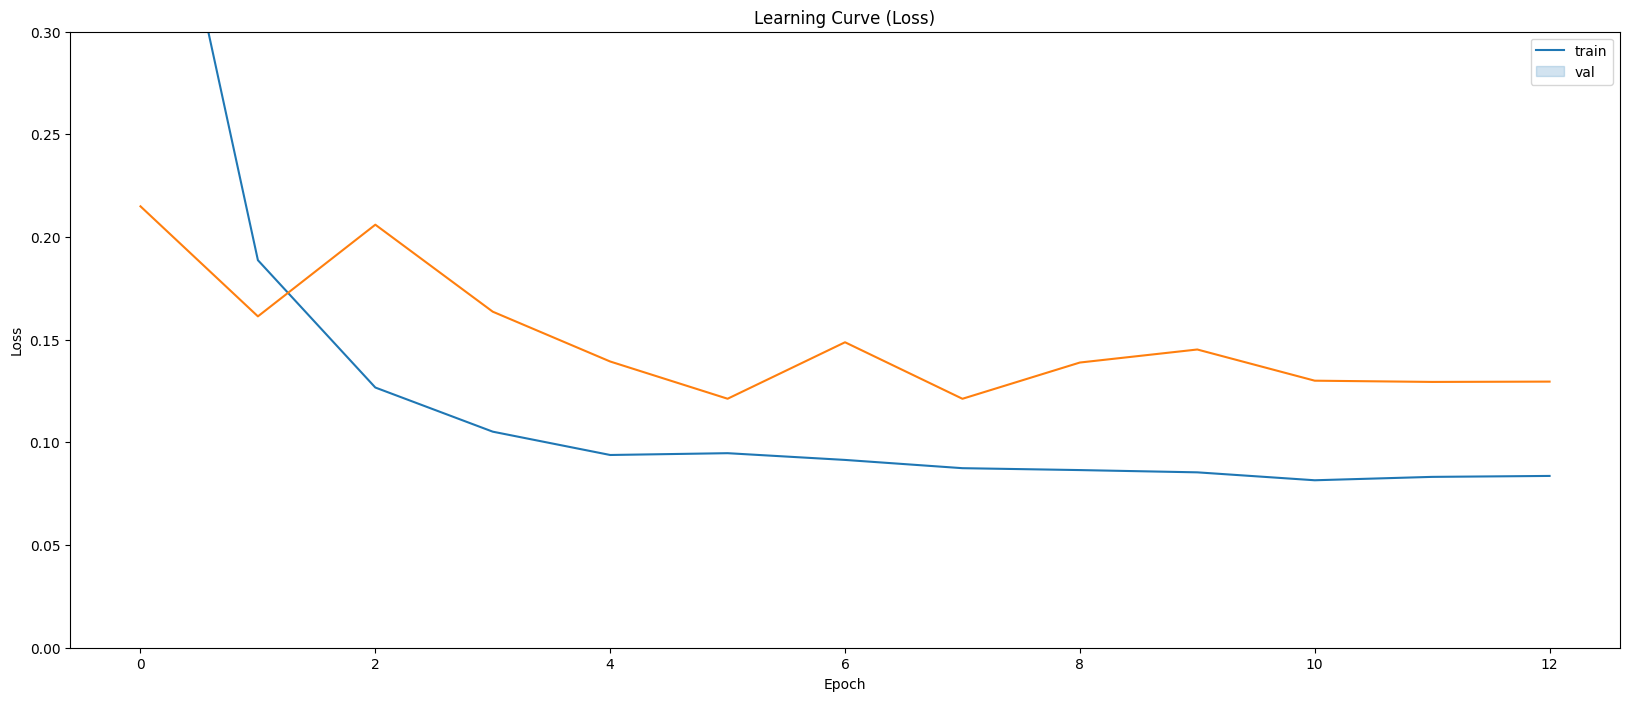

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.3)
ax.legend(['train', 'val'], loc='best')
plt.show()

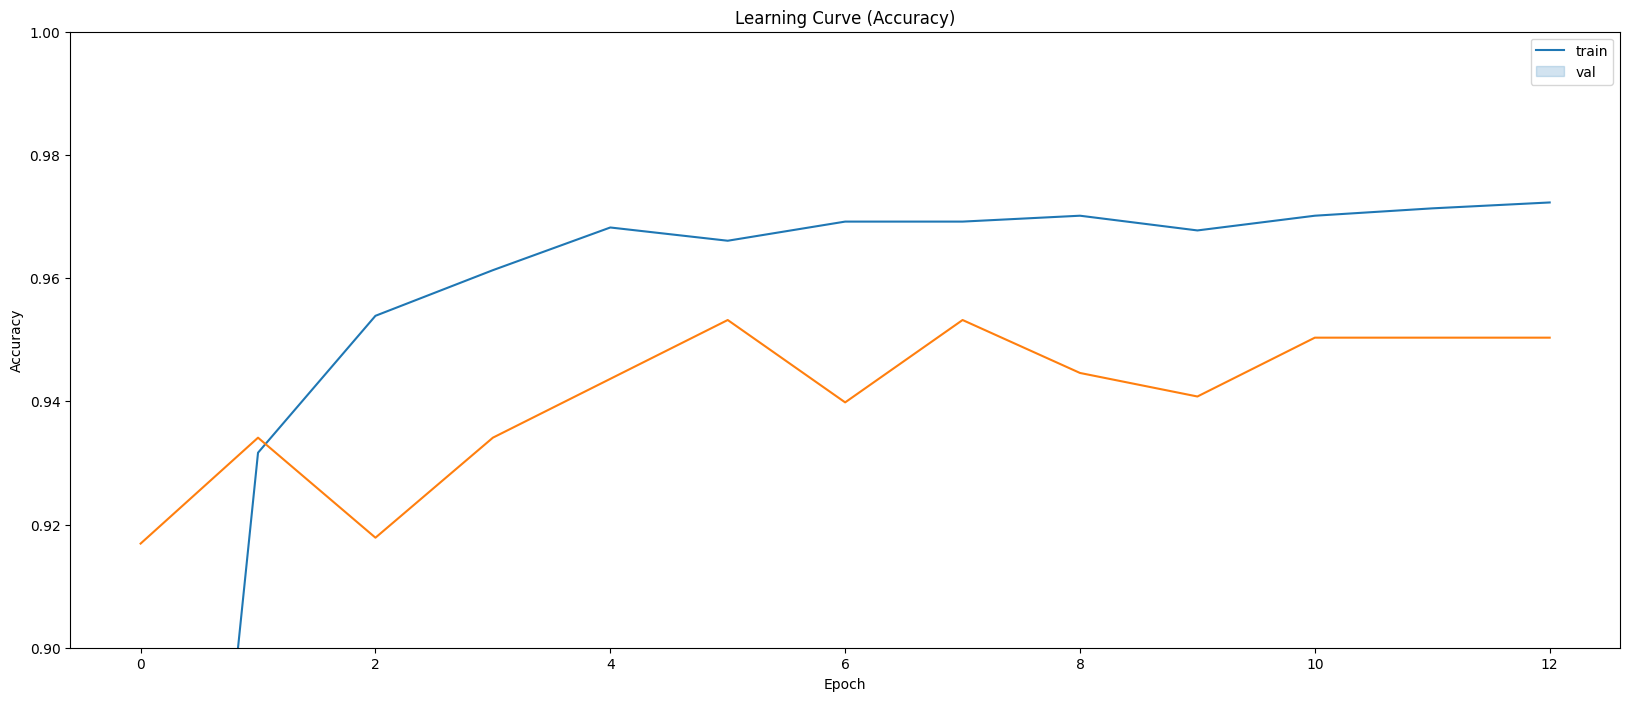

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.90, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [ ]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.12123727798461914
Validation accuracy: 0.9531996250152588


In [ ]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1351291388273239
Test accuracy: 0.9535256624221802


As expected, the fine-tuning approach has reached the best score. We end this notebook by showing a few performance metrics.

# <a id="8">Performance Metrics</a>

In [ ]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [ ]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [ ]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9535256410256411


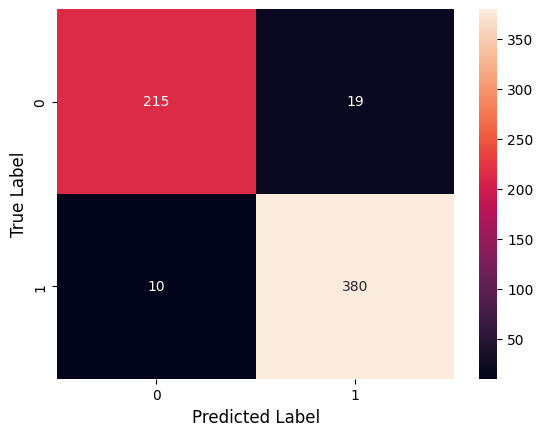

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       234
           1       0.95      0.97      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.95      0.95       624
weighted avg       0.95      0.95      0.95       624



ROC_AUC:  0.9877164146394917


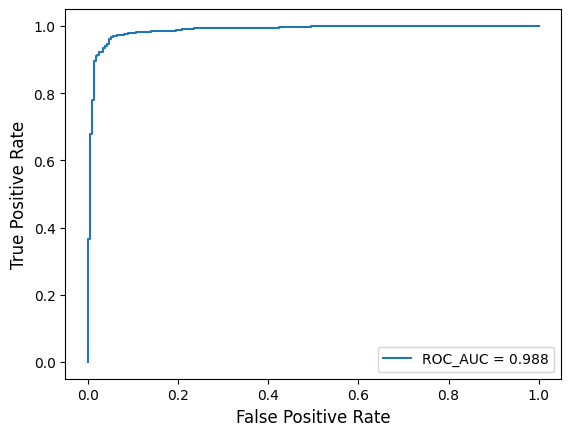

In [ ]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)
plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

Even without expertise on the medical field, it’s reasonable to assume that false negatives are more ‘costly’ than false positives in this case. Reaching such recall with a relatively small dataset for training as this one, while also reaching a pretty good recall, is a good indicative of the model’s capabilities. Such capabilities are also confirmed by the high ROC-AUC value.

# <a id="9">References</a>

- https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/03_convolutional_neural_networks_in_tensorflow.ipynb
- https://www.tensorflow.org/guide/keras/transfer_learning
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://keras.io/api/applications/
- https://keras.io/api/applications/vgg/